# K-最近邻算法

预计所需时间：**25** 分钟

## 目标

完成本实验后，你将能够：

* 使用K-最近邻算法对数据进行分类


在本实验中，你将加载一个客户数据集，拟合数据，并使用K-最近邻算法来预测一个数据点。但什么是 **K-最近邻算法** 呢？


**K-最近邻算法** 是一种监督学习算法。在这种算法中，数据通过与其分类相对应的数据点进行“训练”。为了预测给定数据点的类别，该算法会考虑“K”个最近数据点的类别，并选择其中大多数“K”个最近数据点所属的类别作为预测类别。


### 可视化KNN算法示意图

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/images/KNN_Diagram.png">


在这种情况下，我们有A类和B类的数据点。我们想预测中间那颗红色星形数据点的类别。如果我们考虑k值为3（3个最近的数据点），我们将预测其为B类。然而，如果我们考虑k值为6，我们将预测其为A类。

从这个意义上说，考虑k值是很重要的。希望通过这个图示，你能理解K-最近邻算法的概念。它在预测测试点的分类时，会考虑“K”个最近邻（数据点）。

<h1>目录</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#about_dataset">关于数据集</a></li>
        <li><a href="https://#visualization_analysis">数据可视化和分析</a></li>
        <li><a href="https://#classification">分类</a></li>
    </ol>
</div>
<br>
<hr>


In [ ]:
!pip install scikit-learn==0.23.1

Let's load required libraries


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## 关于数据集
假设某电信提供商根据服务使用模式对其客户群进行了细分，将客户分为四组。如果可以使用人口统计数据来预测组成员身份，公司就可以为个别潜在客户定制优惠。这是一个分类问题。也就是说，给定预定义标签的数据集，我们需要构建一个模型来预测新案例或未知案例的类别。

该示例侧重于使用人口统计数据（例如地区、年龄和婚姻状况）来预测使用模式。

目标字段称为 **custcat**，具有四个可能的值，对应于四个客户群，分别如下：
1. 基本服务
2. 电子服务
3. 增值服务
4. 全面服务

我们的目标是构建一个分类器，以预测未知案例的类别。我们将使用一种特定类型的分类方法，称为K最近邻算法。


### 读取数据

In [24]:
# 原始数据地址：
#!curl https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/teleCust1000t.csv -o teleCust100t1.csv

使用pandas库预览数据

In [2]:
df = pd.read_csv('teleCust100t.csv')
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


<div id="visualization_analysis">
    <h2>数据可视化和分析</h2> 
</div>


#### 查看各个客户分类的数量

In [3]:
df['custcat'].value_counts()

custcat
3    281
1    266
4    236
2    217
Name: count, dtype: int64

#### 281名增值服务客户、266名基本服务客户、236名全面服务客户和217名电子服务客户

可以使用python提供的可视化工具生成柱状图：

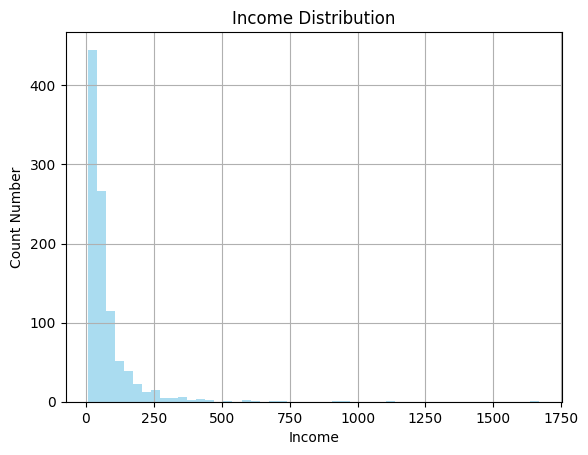

In [4]:
df.hist(column='income', bins=50, color='skyblue', alpha=0.7)
# sns.histplot(df['income'], bins=50, kde=True, color='skyblue')

plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count Number')
plt.show()

### 设置特性


定义特性集合，X


In [5]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

要使用scikit-learn库，我们必须将Pandas数据框转换为Numpy数组：

In [6]:
X = df[['region', 'tenure','age', 'marital', 'address', 'income', 'ed', 'employ','retire', 'gender', 'reside']] .values  #.astype(float)
X[0:5]


array([[  2.,  13.,  44.,   1.,   9.,  64.,   4.,   5.,   0.,   0.,   2.],
       [  3.,  11.,  33.,   1.,   7., 136.,   5.,   5.,   0.,   0.,   6.],
       [  3.,  68.,  52.,   1.,  24., 116.,   1.,  29.,   0.,   1.,   2.],
       [  2.,  33.,  33.,   0.,  12.,  33.,   2.,   0.,   0.,   1.,   1.],
       [  2.,  23.,  30.,   1.,   9.,  30.,   1.,   2.,   0.,   0.,   4.]])

In [7]:
y = df['custcat'].values
y[0:5]

array([1, 4, 3, 1, 3])

## 数据归一化

数据标准化使数据具有零均值和单位方差，这是一个良好的实践，尤其对于像KNN这样的基于数据点距离的算法来说：

In [31]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.02696767, -1.055125  ,  0.18450456,  1.0100505 , -0.25303431,
        -0.12650641,  1.0877526 , -0.5941226 , -0.22207644, -1.03459817,
        -0.23065004],
       [ 1.19883553, -1.14880563, -0.69181243,  1.0100505 , -0.4514148 ,
         0.54644972,  1.9062271 , -0.5941226 , -0.22207644, -1.03459817,
         2.55666158],
       [ 1.19883553,  1.52109247,  0.82182601,  1.0100505 ,  1.23481934,
         0.35951747, -1.36767088,  1.78752803, -0.22207644,  0.96655883,
        -0.23065004],
       [-0.02696767, -0.11831864, -0.69181243, -0.9900495 ,  0.04453642,
        -0.41625141, -0.54919639, -1.09029981, -0.22207644,  0.96655883,
        -0.92747794],
       [-0.02696767, -0.58672182, -0.93080797,  1.0100505 , -0.25303431,
        -0.44429125, -1.36767088, -0.89182893, -0.22207644, -1.03459817,
         1.16300577]])

### 训练测试拆分

样本外准确率是模型在未训练数据上进行正确预测的百分比。对同一数据集进行训练和测试，由于模型过拟合的可能性，样本外准确率往往较低。

我们的模型必须具有较高的样本外准确率，因为任何模型的目的当然是在未知数据上进行正确的预测。那么，我们如何提高样本外准确率呢？一种方法是使用一种称为训练/测试拆分的评估方法。训练/测试拆分涉及将数据集分别拆分为训练集和测试集，它们是互斥的。之后，你用训练集进行训练，用测试集进行测试。

因为测试数据集不是用于训练模型的数据集的一部分，这将提供更准确的样本外准确率评估。这对于现实世界的问题更为现实。


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (800, 11) (800,)
Test set: (200, 11) (200,)


<div id="classification">
    <h2>分类</h2>
</div>

<h3>K-最近邻算法（KNN）</h3>


实现k-最近邻投票的分类器

In [11]:
from sklearn.neighbors import KNeighborsClassifier

### 训练模型

让我们现在以k=4开始算法：


In [10]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

### 预测

我们可以使用模型对测试集进行预测：


In [17]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([3, 1, 3, 4, 4])

### 准确性评估

在多标签分类中，**准确性分类得分** 是一个计算子集准确率的函数。该函数等同于jaccard_score函数。它实际上计算了测试集中实际标签和预测标签的匹配程度。


In [20]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.5575
Test set Accuracy:  0.26


#### 其他的K值呢？

KNN中的K是要检查的最近邻的数量。它需要由用户指定。那么，我们如何选择合适的K值呢？
一般的解决方案是保留一部分数据用于测试模型的准确性。然后选择k=1，使用训练部分进行建模，并使用测试集中的所有样本计算预测的准确性。重复此过程，逐步增加k，看看哪个k对你的模型来说是最好的。

我们可以计算KNN在不同k值下的准确性。

In [21]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.27 , 0.31 , 0.275, 0.26 , 0.3  , 0.29 , 0.345, 0.33 , 0.32 ])

#### 绘制模型在不同邻居数量下的准确性。


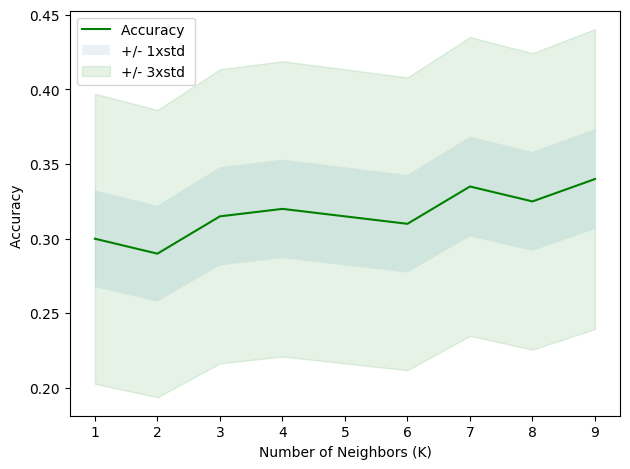

In [39]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [40]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.34 with k= 9


### 代码解析

#### mean_acc
- **mean_acc**：这是一个数组，用于存储不同 K 值对应的模型准确率。在循环中，对于每个 K 值，模型的准确率被计算并存储在 mean_acc 中。

#### std_acc
- **std_acc**：这是一个数组，用于存储不同 K 值对应的标准误差。标准误差反映了模型预测的准确率的变异程度，即预测值的波动性。

#### +/- 1xstd
- **+/- 1xstd**：表示一个标准误差范围内的准确率区间。这个区间反映了预测准确率的一倍标准误差范围内的波动性。

#### +/- 3xstd
- **+/- 3xstd**：表示三个标准误差范围内的准确率区间。这个区间反映了预测准确率的三倍标准误差范围内的波动性。
